# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


# PROJECT DESCRIPTION
There are two main goals: 
- Predicting recipes that will result in high traffic.
- Achieving an 80% accuracy in predicting high traffic recipes.

Our first step is to load the data in a pandas dataframe so we can work with it. 

In [1]:
# Basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# EDA
from scipy.stats import boxcox, yeojohnson
from scipy.stats.mstats import winsorize

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 0. Loading the data

In [2]:
df = pd.read_csv("recipe_site_traffic_2212.csv")
df.head(5)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [3]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


# 1. Data Validation:
  - Describe validation and cleaning steps for every column in the data.

We can validate data through the following steps: 
1. Removing duplicates.
2. Checking the values of each columns are the expected ones and adjusting the datatypes of columns.
4. Addressing null values.


## 1.1 Checking Duplicates

In [4]:
#finding the number of duplicates in our dataset
df.duplicated(subset='recipe').sum()

0

As there are no duplicates within our dataframe, there is no need to remove any row. 
Our next step is to check the dimensions of the dataset (rows and columns), together with name, possible values and data types identification.

## 1.2 Checking values and datatypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


From the dataset description, we know that: 

- recipe         | *Numeric* | unique identifier of recipe
- calories       | *Numeric* | number of calories
- carbohydrate   | *Numeric* | amount of carbohydrates in grams
- sugar          | *Numeric* | amount of sugar in grams
- protein        | *Numeric* |  amount of protein in grams
- category       | *Character* |  type of recipe. Recipes are listed in one of ten possible groupings.
- servings       | *Numeric* |  number of servings for the recipe
- high_traffic   | *Character* |  if the traffic to the site was high, this is marked with “High”.

From the info obtained through the `.info()` method we observe that servings has a different data type.

Let's see why it is so...

In [6]:
servings_values = set(df["servings"])
print(f"The values of the 'servings' columns are: {servings_values}")

The values of the 'servings' columns are: {'4 as a snack', '6 as a snack', '2', '6', '1', '4'}


In [7]:
#checking the count of all values of servings column
df['servings'].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

We see there are two records that contain string instead of a single numeric value. This is why we need to replace them: 

In [8]:
#replacing the rows that contain "as a snack" with their numeric value
df['servings'] = df['servings'].str.replace(" as a snack", "")

#checking the values of servings columns to validate it
df['servings'].value_counts()

4    391
6    198
2    183
1    175
Name: servings, dtype: int64

Before chacking datatypes, let's check all columns contain the expected values:

In [9]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


From the `.describe()`command we already see our id (recipe) contains 947 values and that all numerical columns make sense. 
Just to be sure, we check the unique number of records in the recipe columns. 

In [10]:
# checking there are 947 unique values in the recipe
df['recipe'].nunique()

947

Now let's check the string variables: 

In [11]:
#checking the values of category columns to validate it
df['category'].value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

We observe the there are 11 categories, as there is a duplicate in the 'chicken' with two different options: 
- 'chicken' -> The one we expected. 
- 'chicken breast' -> This was not contained in our describing sheet. 

Therefore, we correct them so there are only 10 options.

In [12]:
#replacing the rows that contain "as a snack" with their numeric value
df['category'] = df['category'].str.replace(" Breast", "")

#checking the values of servings columns to validate it
df['category'].value_counts()

Chicken          172
Breakfast        106
Beverages         92
Lunch/Snacks      89
Potato            88
Pork              84
Vegetable         83
Dessert           83
Meat              79
One Dish Meal     71
Name: category, dtype: int64

In [13]:
#converting data type of category column to category
df['category'] = df['category'].astype('category')

Now it is fixed. We just need to check the high_traffic variable, that we know only contains values for those recipes that have showed a high traffic. 

In [14]:
#checking the values of high_traffic columns to validate it
df['high_traffic'].value_counts()

High    574
Name: high_traffic, dtype: int64

For the model generation, it will be more useful that the high_traffic variable is a boolean one. So we will convert it to a boolean variable. 

In [15]:
#replacing the rows with value "High" with True, and null values with False
df['high_traffic'] = np.where(df['high_traffic'] == "High", True, False)

#checking the values of high_traffic column again
df['high_traffic'].value_counts()

True     574
False    373
Name: high_traffic, dtype: int64

Now let's fix all the data types:

In [16]:
#converting data type of servings column to integer
df['servings'] = df['servings'].astype('int')

In [17]:
# We check our dataframe again
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        947 non-null    int64   
 1   calories      895 non-null    float64 
 2   carbohydrate  895 non-null    float64 
 3   sugar         895 non-null    float64 
 4   protein       895 non-null    float64 
 5   category      947 non-null    category
 6   servings      947 non-null    int64   
 7   high_traffic  947 non-null    bool    
dtypes: bool(1), category(1), float64(4), int64(2)
memory usage: 46.7 KB


## 1.3 Checking the null values

Now all variables present the right type. So let's see what variables contain nulls and why. 

In [18]:
df.isnull().sum()

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

We see only the 'calories', 'carbohydrate', 'sugar' and 'protein' contain nulls, and all of them contain the same number of null values. 

In [19]:
#showing all rows with missing values
df[df.isnull().any(axis=1)]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,True
23,24,NaN,NaN,NaN,NaN,Meat,2,False
48,49,NaN,NaN,NaN,NaN,Chicken,4,False
82,83,NaN,NaN,NaN,NaN,Meat,4,True
89,90,NaN,NaN,NaN,NaN,Pork,6,True
116,117,NaN,NaN,NaN,NaN,Chicken,6,True
121,122,NaN,NaN,NaN,NaN,Dessert,2,True
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,True
149,150,NaN,NaN,NaN,NaN,Potato,2,True
187,188,NaN,NaN,NaN,NaN,Pork,4,True


As there are 52 rows that contain all 4 columns with a null value, the best option is to remove them from our dataset. 

In [20]:
#dropping missing values
df = df.dropna().reset_index(drop=True)

#checking missing numbers for each columns
df.isna().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

We check one last time the summary information of our data just to make sure it is ready. 

In [21]:
#checking the summary of dataframe's structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        895 non-null    int64   
 1   calories      895 non-null    float64 
 2   carbohydrate  895 non-null    float64 
 3   sugar         895 non-null    float64 
 4   protein       895 non-null    float64 
 5   category      895 non-null    category
 6   servings      895 non-null    int64   
 7   high_traffic  895 non-null    bool    
dtypes: bool(1), category(1), float64(4), int64(2)
memory usage: 44.2 KB


As a last characteristic to check, let's see if our dataset is balanced or imbalanced.

Chicken          163
Breakfast        106
Beverages         92
Potato            83
Lunch/Snacks      82
Vegetable         78
Dessert           77
Meat              74
Pork              73
One Dish Meal     67
Name: category, dtype: int64


<AxesSubplot: xlabel='count', ylabel='category'>

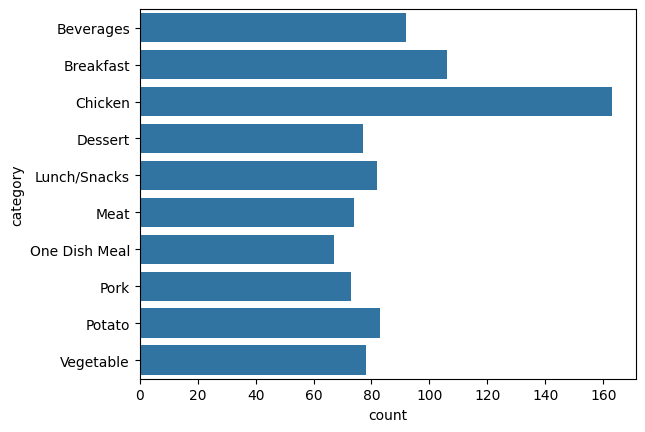

In [22]:
#We can check the distribution of individuals we have for each specie. Remember that strongly imabalanced datasets can be a problem. 
print(df["category"].value_counts())
sns.countplot(df["category"])

As we can observe in the previous chart, our dataset contains a similar number of cases for all categories but chicken, that presents a bigger amount. However, there are still enough cases to consider all categories. 

With the data already validates and clean, our dataframe is now prepared to the EDA phase. 

# 2. Exploratory Analysis  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings

So now can compute descriptive statistics for each numerical column within the dataframe. 
The key goal of this step is: 
- **Get valuable insights into the characteristics of the data.**

In [23]:
#generating descriptive statistic for our dataframe
# Get all column names excluding 'recipe'
cols_to_describe = set(df.columns) - {'recipe'}

# Describe the dataframe excluding the 'recipe' column
df[cols_to_describe].describe()


,calories,sugar,protein,servings,carbohydrate
count,895.000000,895.000000,895.000000,895.000000,895.000000
mean,435.939196,9.046547,24.149296,3.458101,35.069676
std,453.020997,14.679176,36.369739,1.735979,43.949032
min,0.140000,0.010000,0.000000,1.000000,0.030000
25%,110.430000,1.690000,3.195000,2.000000,8.375000
50%,288.550000,4.550000,10.800000,4.000000,21.480000
75%,597.650000,9.800000,30.200000,4.000000,44.965000
max,3633.160000,148.750000,363.360000,6.000000,530.420000


From the previous information, we can already conclude some first insights: 

- There is a notable standart deviation, mainly in the 'calories', 'carbohydrate', 'sugar' and 'protein' columns. 
- The quartiles indicate the presence of outliers in all columns -> I will assess this in the following section.  

As a result, we can deduce that the value distribution is non-normal and reght-skewed, highlighting that the median is a more representative measure for these column (insteaf of using the mean).

Now let's observe if there is a relationship between different variables:

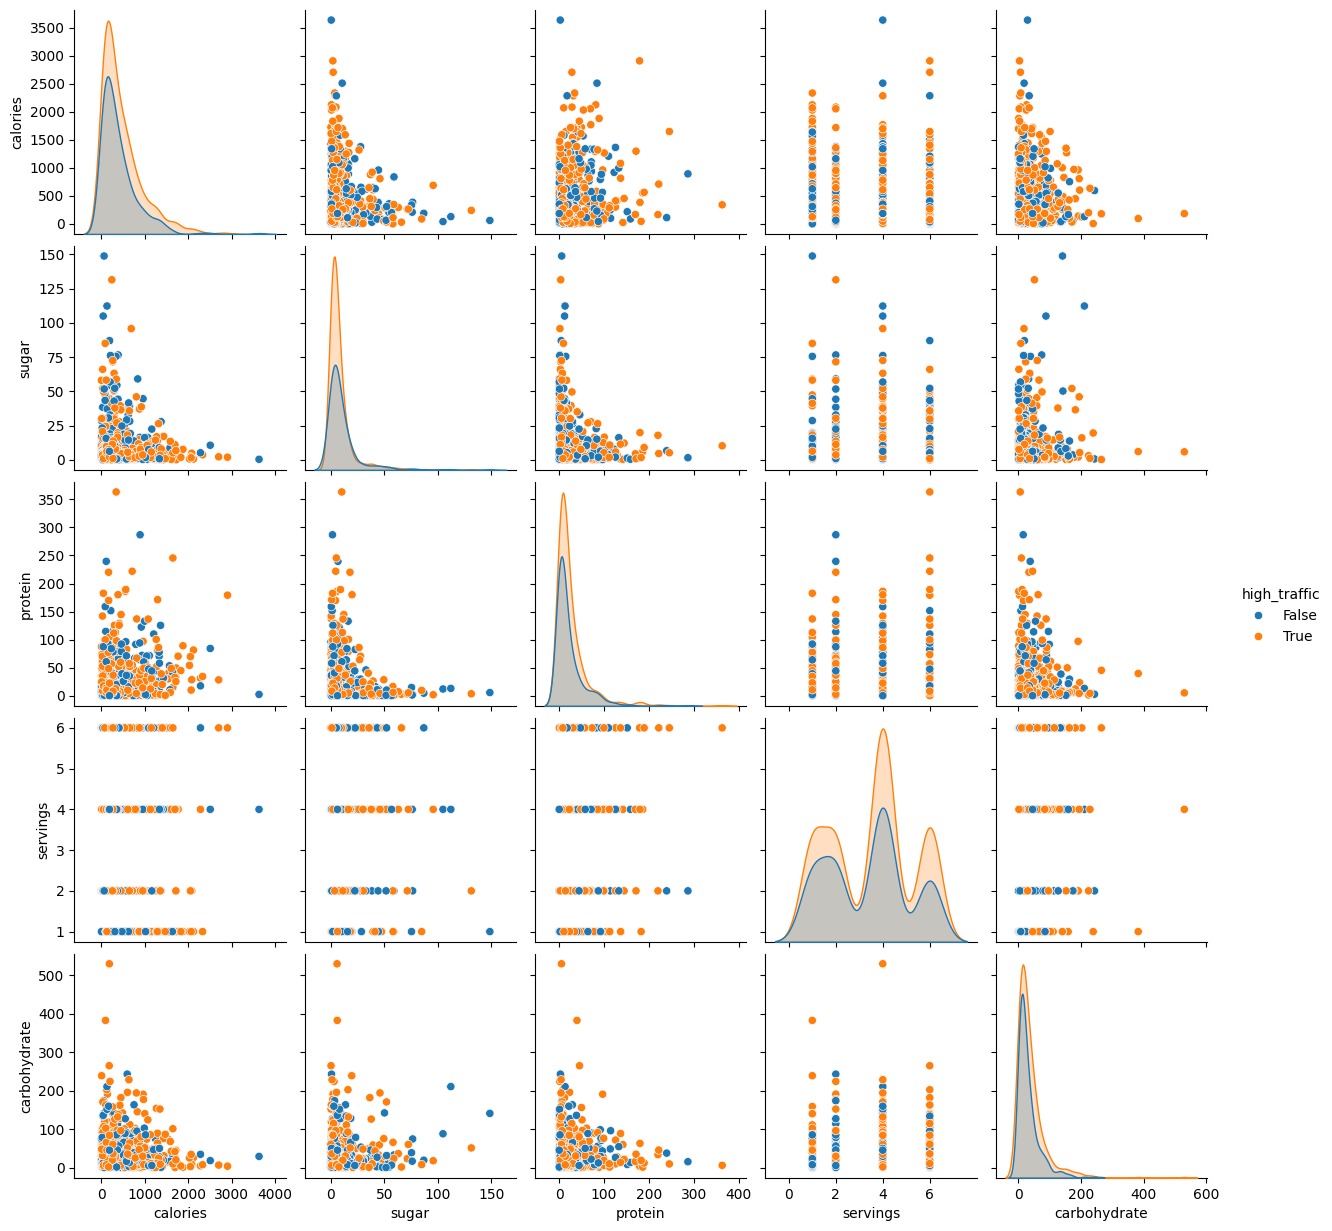

In [24]:
# For the analytics, I substract again the 'recipe' columns.
cols_to_describe = set(df.columns) - {'recipe'}

sns.pairplot(df[cols_to_describe], hue='high_traffic')
plt.show()


From the previous plots we observe there is no much correlation between those columns. Now let's check their distribution:

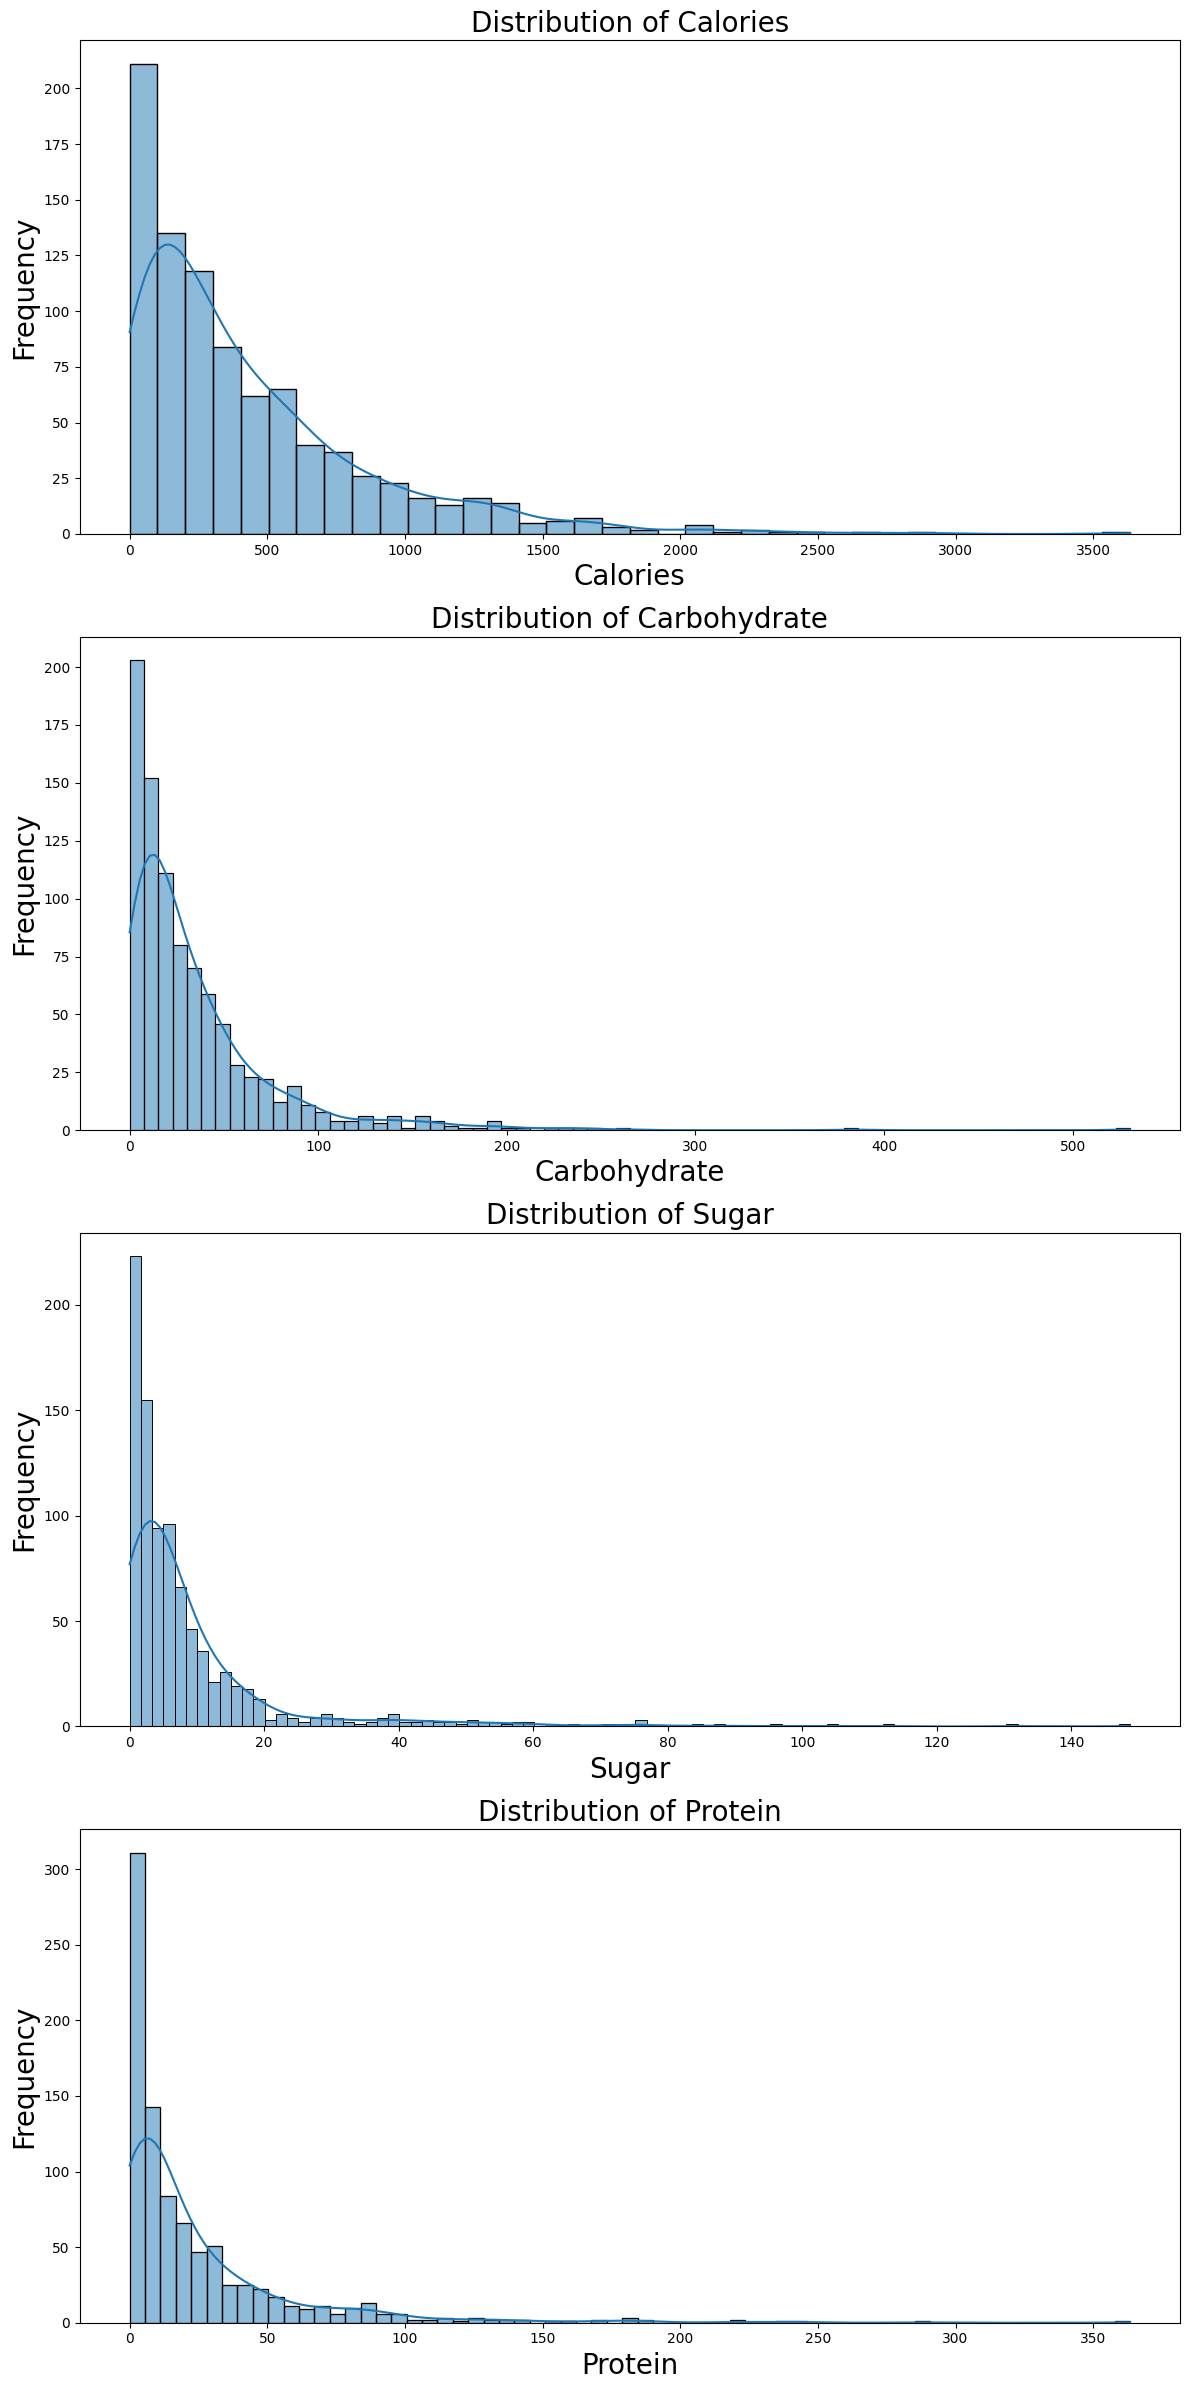

In [25]:
#considering only numerical columns
numerical_columns =  df.select_dtypes(include='float').columns

#subplots with the desired number of rows and columns
num_rows = len(numerical_columns)
fig, axes = plt.subplots(num_rows, 1, figsize=(12, 6 * num_rows))

#iterating over the numerical columns and plot the distributions
for i, column in enumerate(numerical_columns):
    ax = axes[i] if num_rows > 1 else axes
    sns.histplot(data=df, x=column, ax=ax, kde=True,)
    ax.set_title(f"Distribution of {column.capitalize()}", fontsize = 20)
    ax.set_xlabel(column.capitalize(), fontsize=20)  # Set x-axis label with increased font size
    ax.set_ylabel('Frequency', fontsize=20)  # Set y-axis label with increased font size

#adjust the spacing between subplots
plt.tight_layout()
plt.show()

We can observe in all 4 numerical columns that the dataset consists of lower values, which makes the data right-skewed. 
This can be further noticed with the Kernel Density Estimation (KDE). 

Now let's try to focus on outliers and check if there are, we can use the boxplots for this: 

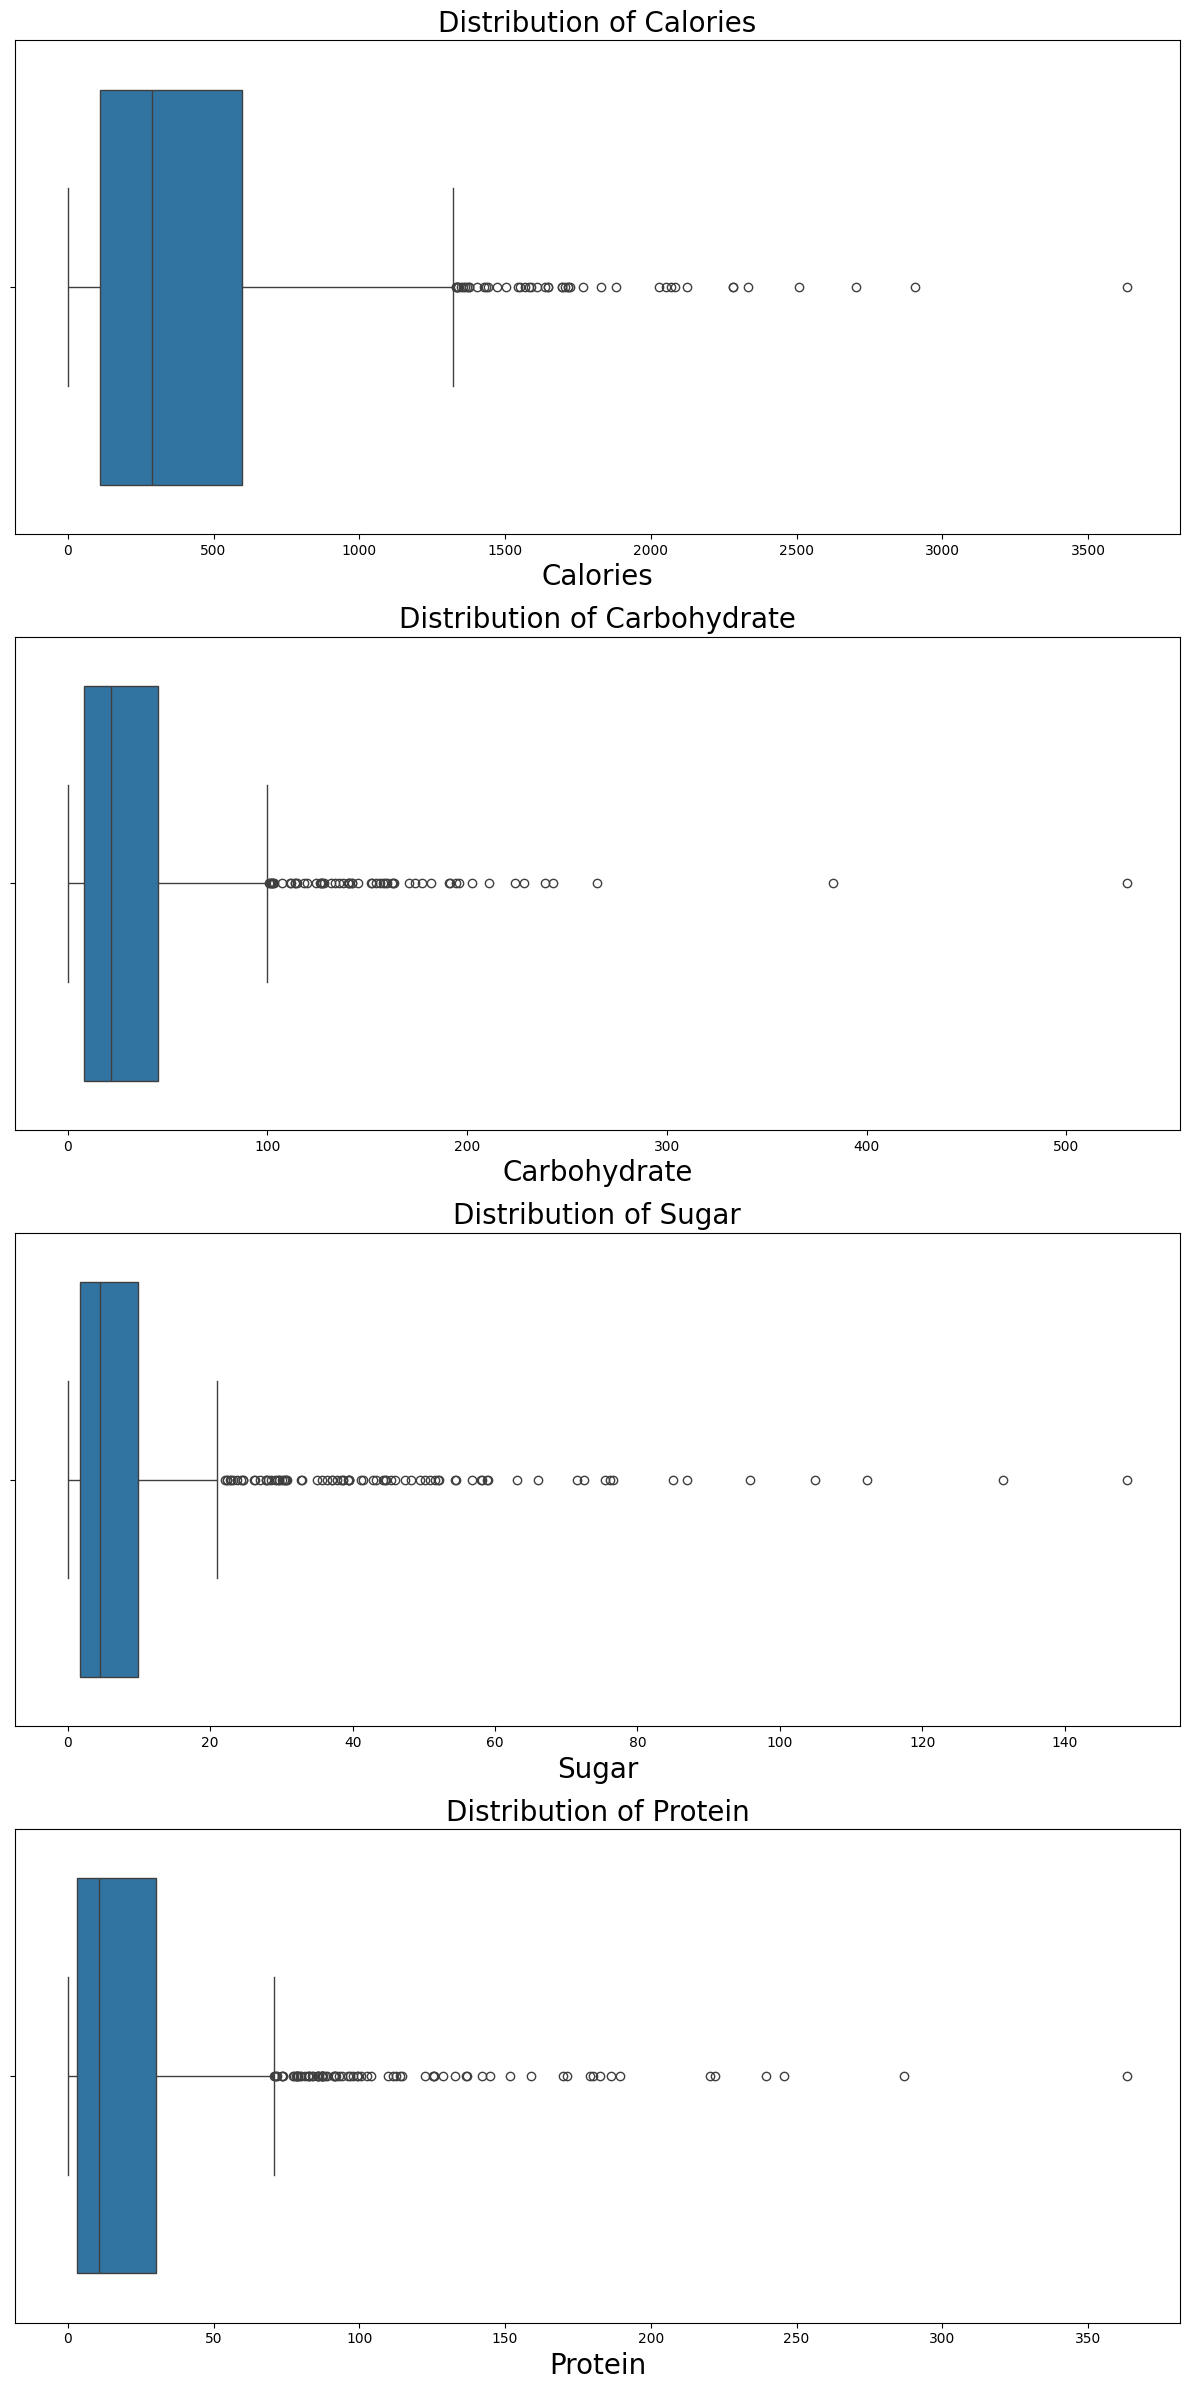

In [26]:
#considering only numerical columns
numerical_columns =  df.select_dtypes(include='float').columns

#subplots with the desired number of rows and columns
num_rows = len(numerical_columns)
fig, axes = plt.subplots(num_rows, 1, figsize=(12, 6 * num_rows))

#iterating over the numerical columns and plot the distributions
for i, column in enumerate(numerical_columns):
    ax = axes[i] if num_rows > 1 else axes
    sns.boxplot(data=df, x=column, ax=ax)
    ax.set_title(f"Distribution of {column.capitalize()}", fontsize = 20)
    ax.set_xlabel(column.capitalize(), fontsize=20)  # Set x-axis label with increased font size

#adjust the spacing between subplots
plt.tight_layout()
plt.show()

The boxplots make evidence the existence of outliers and the right-skewness present in those columns. 

So, what can we do to further analyze this dataset?

Let's try to understand what role play the categories of the dataset. From now on, the median will be used as the standard metric to analyze the data.

So let's see the median nutritional value for each category: 

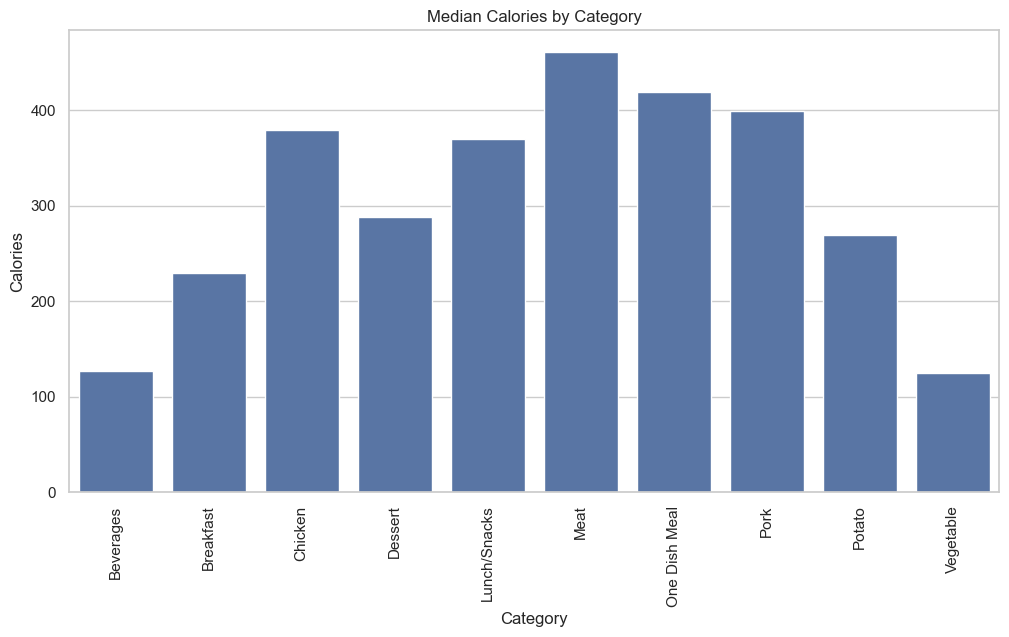

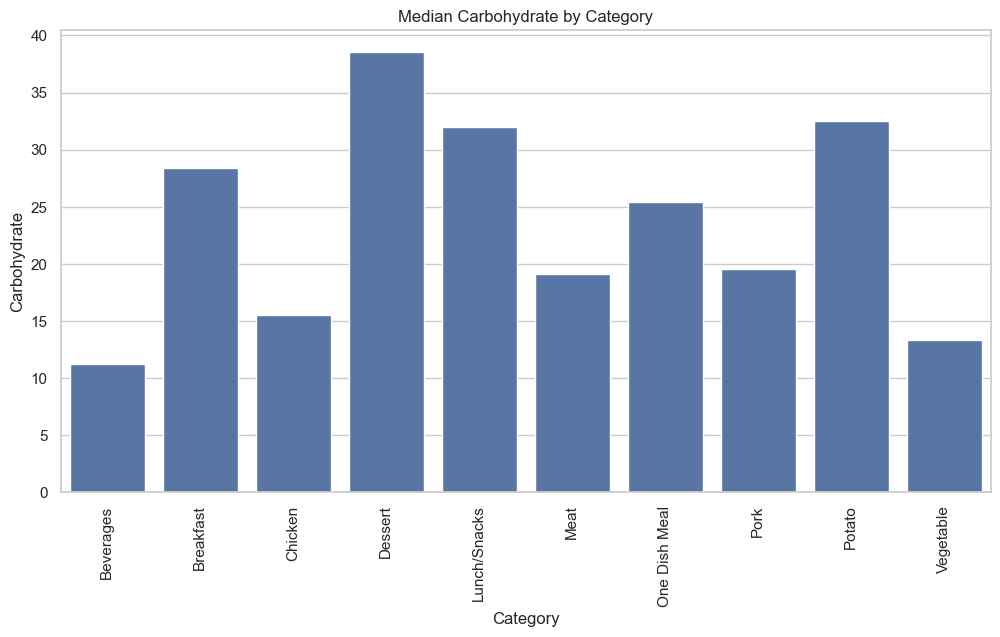

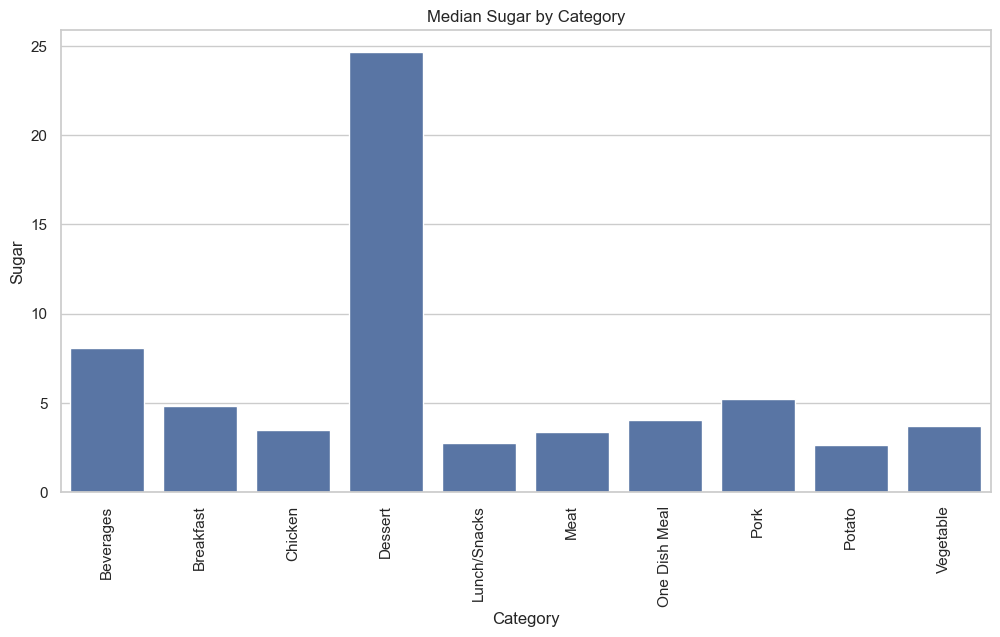

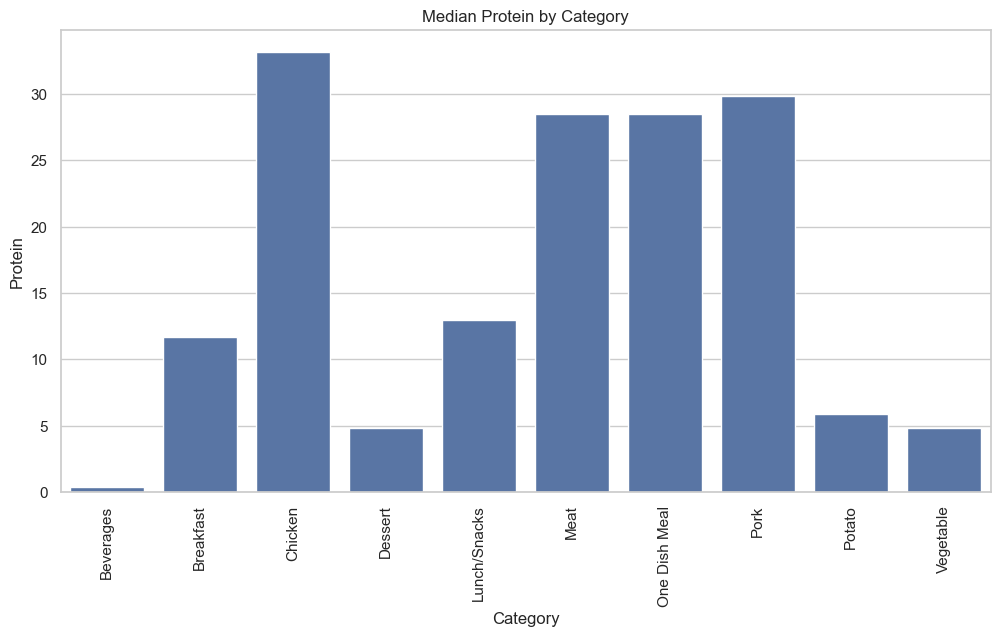

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Group by category and high_traffic, calculate median
category_medians = df.groupby("category")[numerical_columns].median().reset_index()

# Seaborn style
sns.set(style="whitegrid")

for column in numerical_columns:
    plt.figure(figsize=(12, 6))
    
    # Create a bar plot with seaborn
    ax = sns.barplot(
        x='category', 
        y=column, 
        data=category_medians,
    )
    
    # Set axis labels and title
    ax.set_xlabel("Category")
    ax.set_ylabel(column.capitalize())
    ax.set_title(f"Median {column.capitalize()} by Category")
    
    # Rotate x axis ticks
    plt.xticks(rotation=90)
    
    # Show the plot
    plt.show()


We observe that the median values of all four nutritional variables extremely depends on the category, which does not allow to extract any conclusion. 

Let's see if there is some common trend when comparing with the high_traffic boolean value. 

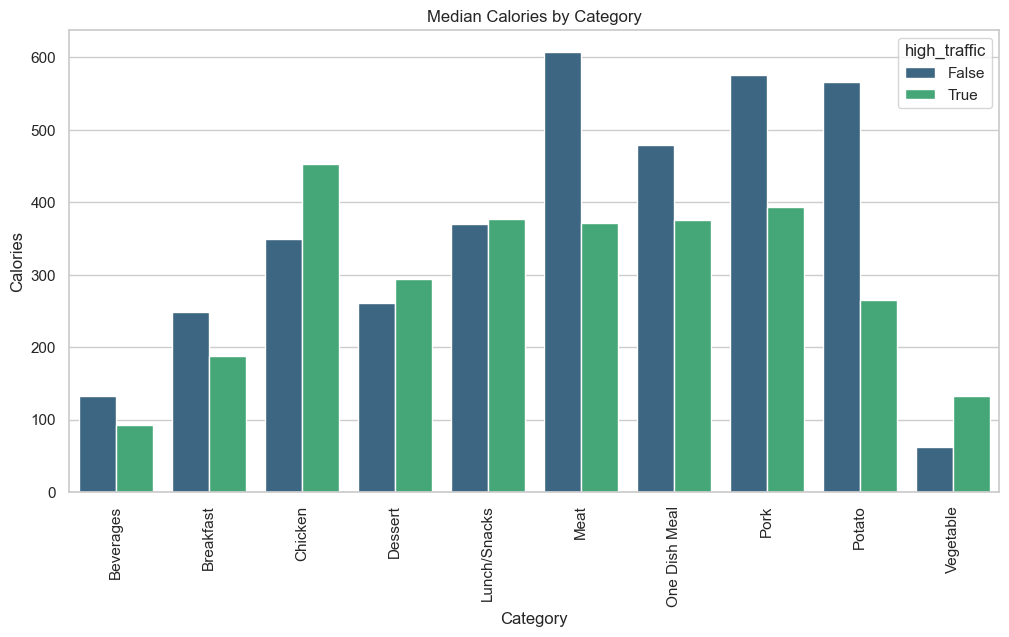

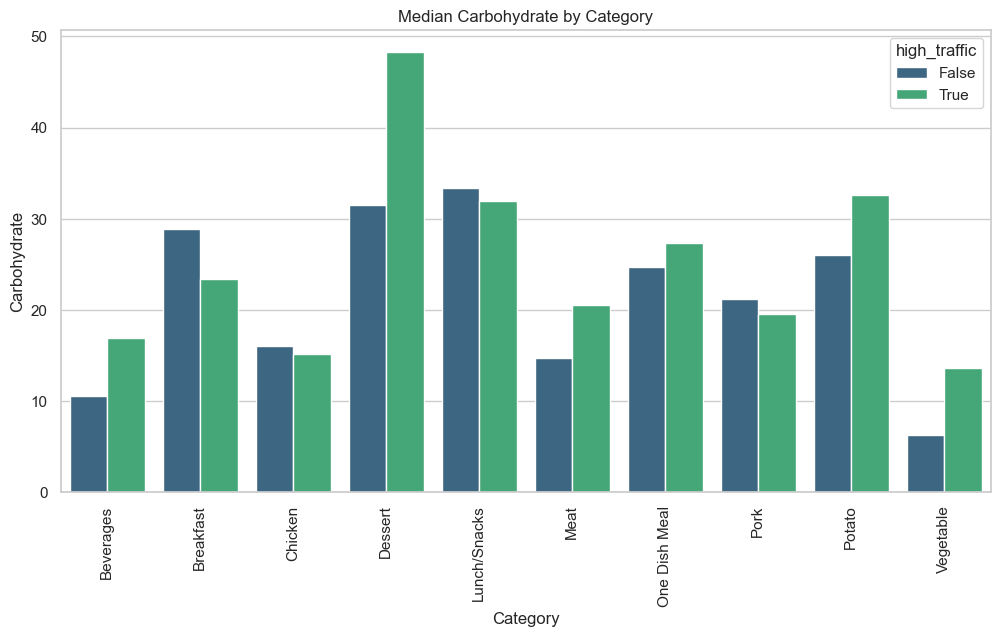

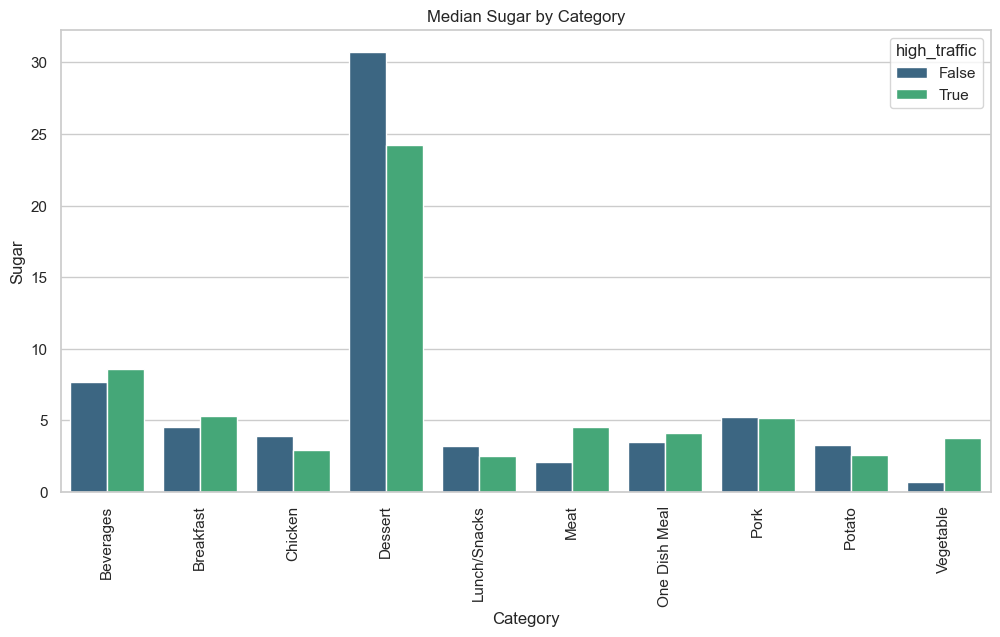

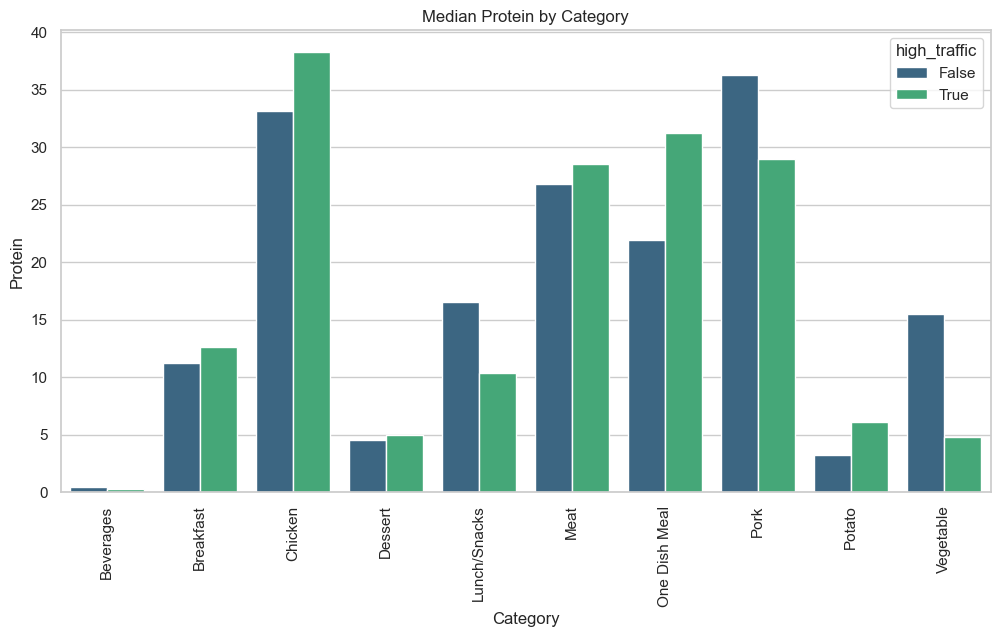

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Group by category and high_traffic, calculate median
category_medians = df.groupby(["category", "high_traffic"])[numerical_columns].median().reset_index()

# Seaborn style
sns.set(style="whitegrid")

for column in numerical_columns:
    plt.figure(figsize=(12, 6))
    
    # Create a bar plot with seaborn
    ax = sns.barplot(
        x='category', 
        y=column, 
        hue='high_traffic', # This will automatically create different bars for True and False
        data=category_medians,
        palette='viridis' # This sets the color palette, you can change it as per your preference
    )
    
    # Set axis labels and title
    ax.set_xlabel("Category")
    ax.set_ylabel(column.capitalize())
    ax.set_title(f"Median {column.capitalize()} by Category")
    
    # Rotate x axis ticks
    plt.xticks(rotation=90)
    
    # Show the plot
    plt.show()


Again we can not conclude much about the previous information, as there is no common trend. 
So now, let's try to correlate the categories with the high traffic. 
To do so, we can easily observe how many high_traffic posts happened for each category. 

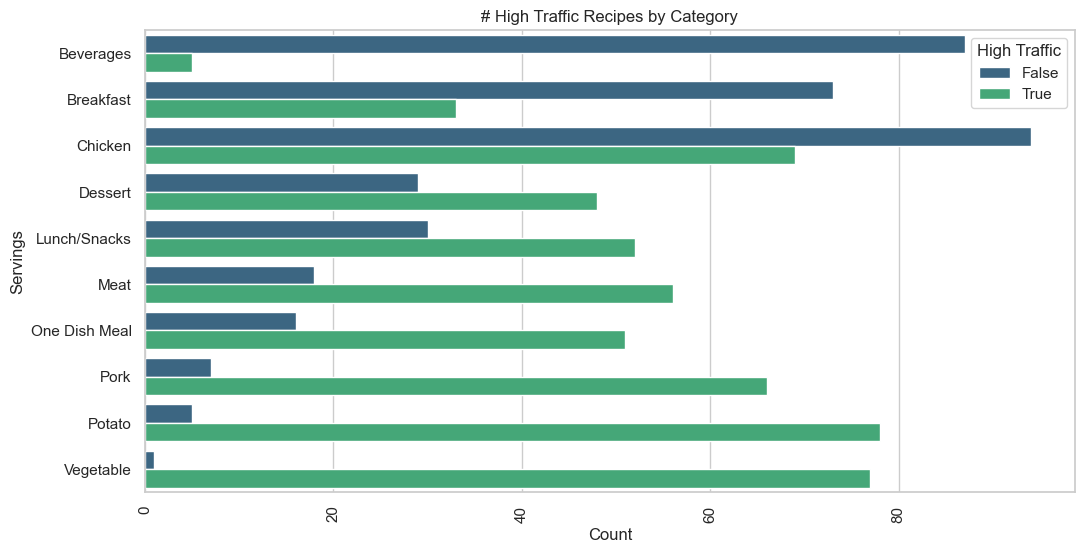

In [29]:
#create a count plot
plt.figure(figsize=(12, 6))
sns.countplot(y="category", hue="high_traffic", data=df, palette='viridis')

#set x and y axis labels
plt.xlabel("Count")
plt.ylabel("Servings")

#set title
plt.title("# High Traffic Recipes by Category")

#set x axis ticks
plt.xticks(rotation=90)

#set legend title
plt.legend(title="High Traffic")
plt.show()

Observing the previous chart let us know that there are some categories that tend to showcase an increased traffic. 
Let's observe the proportion of high_traffic for each. 

In [30]:
#group by high_trafic to show how total number of survings is distributed
high_traffic_categories = pd.pivot_table(df, index=["category"], columns=["high_traffic"], values="recipe", aggfunc='count')

# We observe the percentage for each
high_traffic_categories_proportion = round(high_traffic_categories.div(high_traffic_categories.sum(axis=1), axis=0)*100,2)

print(high_traffic_categories_proportion)

high_traffic   False  True 
category                   
Beverages      94.57   5.43
Breakfast      68.87  31.13
Chicken        57.67  42.33
Dessert        37.66  62.34
Lunch/Snacks   36.59  63.41
Meat           24.32  75.68
One Dish Meal  23.88  76.12
Pork            9.59  90.41
Potato          6.02  93.98
Vegetable       1.28  98.72


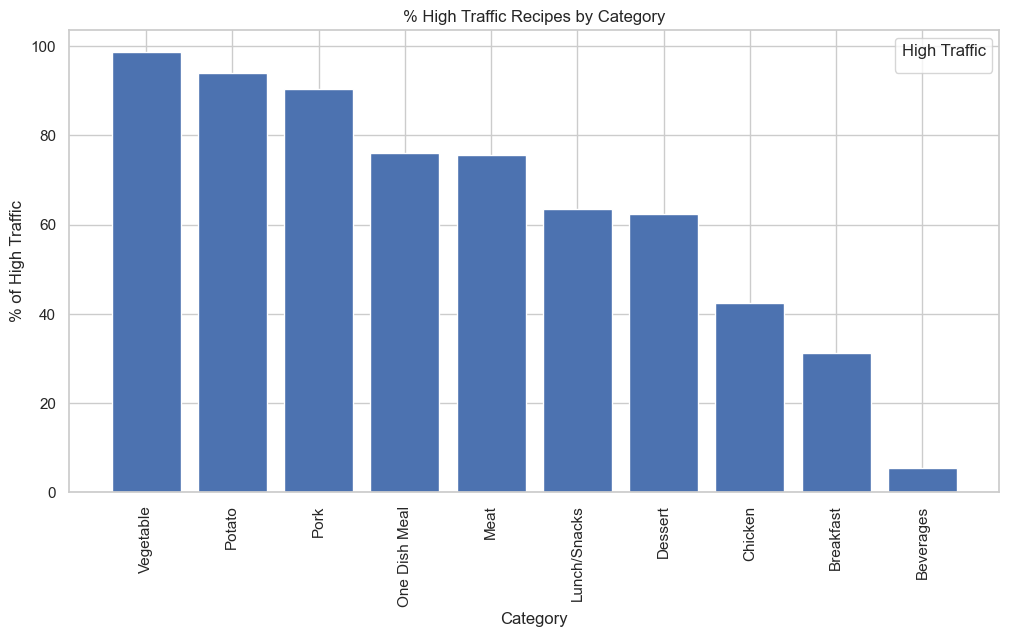

In [31]:
#we order the dataframe in a descending order.
high_traffic_categories_proportion = high_traffic_categories_proportion.sort_values(by=True, ascending=False)
#create a count plot
plt.figure(figsize=(12, 6))
plt.bar(high_traffic_categories_proportion.index, high_traffic_categories_proportion[True].values)

#set x and y axis labels
plt.xlabel("Category")
plt.ylabel("% of High Traffic")

#set title
plt.title("% High Traffic Recipes by Category")

#set x axis ticks
plt.xticks(rotation=90)

#set legend title
plt.legend(title="High Traffic")
plt.show()

The top three categories in terms of high traffic are: 
- Vegetable with a 98,72% of high traffic.
- Potato with a 93,98% of high traffic.
- Pork with a 90,91% of high traffic.

Now let's repeat the same procedure by the number of servings. 

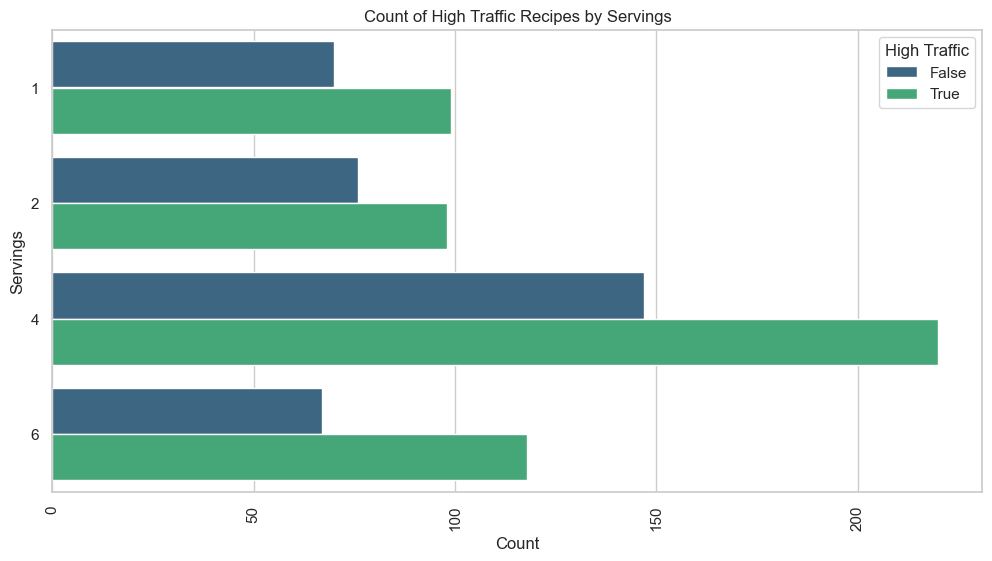

In [32]:
#create a count plot
plt.figure(figsize=(12, 6))
sns.countplot(y="servings", hue="high_traffic", data=df, palette='viridis')

#set x and y axis labels
plt.xlabel("Count")
plt.ylabel("Servings")

#set title
plt.title("Count of High Traffic Recipes by Servings")

#set x axis ticks
plt.xticks(rotation=90)

#set legend title
plt.legend(title="High Traffic")
plt.show()

In [33]:
#group by high_trafic to show how total number of survings is distributed
high_traffic_servings = pd.pivot_table(df, index=["servings"], columns=["high_traffic"], values="recipe", aggfunc='count')

# We observe the percentage for each
high_traffic_servings_proportion = round(high_traffic_servings.div(high_traffic_servings.sum(axis=1), axis=0)*100,2)

print(high_traffic_servings_proportion)

high_traffic  False  True 
servings                  
1             41.42  58.58
2             43.68  56.32
4             40.05  59.95
6             36.22  63.78


In this second case, the proportion of high traffic remains quite constant. Even though the servings for 6 leads the chart with a 63,78% de high_traffic proportion, all proportions are above the 58%.

Now let's assess the outliers computing the IQR for each column and determine the upper and lower boundaries for each. 

In [34]:
#we define a function to calculate upper and lower boundaries of columns
def calculate_outlier_limits(data, factor=1.5):
    # Find 25% and 75% percentiles
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    max_value = np.max(data)
    min_value = np.min(data)
    
    #calculate IQR
    iqr = q3 - q1
    
    #calculate lower and upper boundaries
    lower_limit = q1 - (factor * iqr)
    upper_limit = q3 + (factor * iqr)
    return lower_limit, upper_limit, max_value, min_value

In [35]:
#select numerical columns
numerical_columns = ['calories', 'carbohydrate', 'sugar', 'protein']

#calculate outlier limits for each numerical column
outlier_detection = {}
for column in numerical_columns:
    lower_limit, upper_limit, max_value, min_value = calculate_outlier_limits(df[column])
    outlier_detection[column] = (lower_limit, upper_limit, max_value, min_value)

#check the calculated outlier limits for each column
for column, limits in outlier_detection.items():
    print("_______________________________________")
    print(f"Column: {column}")
    print(f"Max Value: {round(limits[2],1)} and Min Value equals {round(limits[3],1)}")
    print(f"Lower Limit: {round(limits[0],1)}")
    print(f"Upper Limit: {round(limits[1],1)}")
    

_______________________________________
Column: calories
Max Value: 3633.2 and Min Value equals 0.1
Lower Limit: -620.4
Upper Limit: 1328.5
_______________________________________
Column: carbohydrate
Max Value: 530.4 and Min Value equals 0.0
Lower Limit: -46.5
Upper Limit: 99.9
_______________________________________
Column: sugar
Max Value: 148.8 and Min Value equals 0.0
Lower Limit: -10.5
Upper Limit: 22.0
_______________________________________
Column: protein
Max Value: 363.4 and Min Value equals 0.0
Lower Limit: -37.3
Upper Limit: 70.7


There are no problems regarding the low values, as all lower_limits are negative and all the minimal values are close to 0. 
However, all maximal values are way higher than the upper limits, which indicates the existance of outliers. 

Various techniques are available to address this issue. 
- Removal of outliers, even though it leads to significant data loss, making this approach less favorable.
- Capping outliers -> Setting lower and upper limits
- Using winsorization -> Replacing outliers smaller than the X% we define by their corresponding X percentile.
- Standard Deviation method -> Replacing outliers by a capped number based on the standard deviation.

We can try all of them, however, in this case, the best approach is to use the Yeo-Johnson Transformation. This not only deals
with outliers but helps in making the data more normally distributed, which is better suited for the ML models we will use later. 


In [36]:
#specifying the numerical columns to plot
numerical_columns =  df.select_dtypes(include='float').columns

#filter the dataset based on the outlier limits
transformed_data = df.copy()
for column, limits in outlier_detection.items():
    lower_limit = limits[0]
    upper_limit = limits[1]
    #transformed_data = transformed_data[transformed_data[column] <= upper_limit]           # Removing Outliers
    #transformed_data[column] = transformed_data[column].clip(upper=upper_limit)            # Capping Outliers
    #transformed_data[column] = winsorize(transformed_data[column], limits=[0.05, 0.05])    # Winsorization
    transformed_data[column] = yeojohnson(transformed_data[column])[0]                      # Yeo-Johnson Transformation

# Check the filtered dataset
transformed_data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,2,5.742713,4.409023,0.481476,0.653469,Potato,4,True
1,3,17.437755,4.550612,1.224094,1.360783,Breakfast,1,False
2,4,8.416476,4.091120,2.587147,0.019804,Beverages,4,True
3,5,5.133412,1.101661,0.553884,0.425754,Beverages,4,False
4,6,16.024490,1.607528,0.883720,4.049462,One Dish Meal,2,True


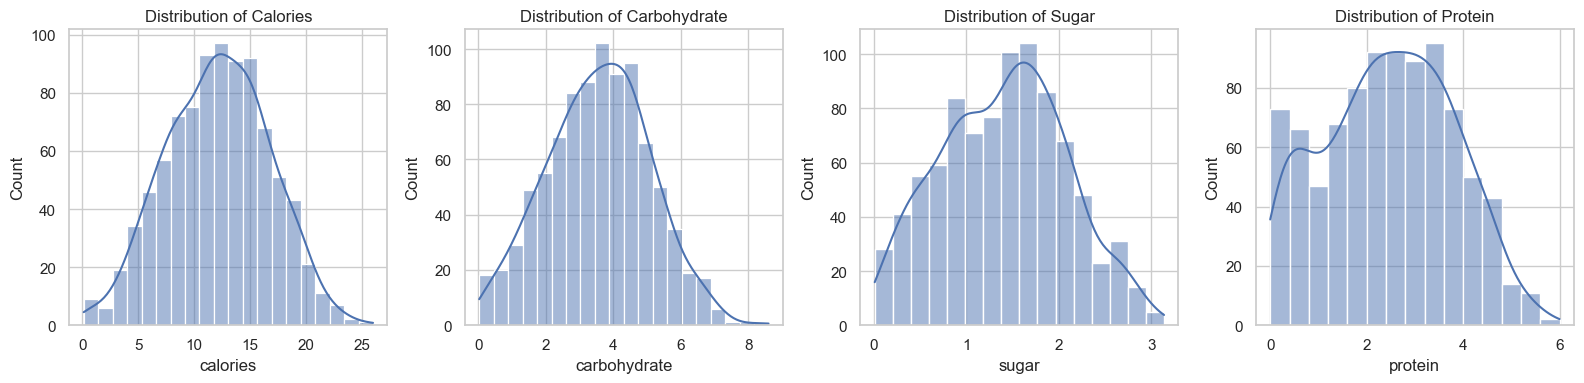

In [37]:
plt.figure(figsize=(16, 4))

#iterating over each column and create a bar plot
for i, column in enumerate(numerical_columns):
    plt.subplot(1, len(numerical_columns), i+1)
    sns.histplot(data=transformed_data, x=column, kde=True)
    plt.title(f"Distribution of {column.capitalize()}")

#adjust the spacing between subplots if needed
plt.tight_layout()
plt.show()

# 3. Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models


The problem we have in the front is determining if a receip will showcase high traffic or not. And this is essential a binary classification problem. 

We have multiple options: 
- Logistic Regression
- Decision Tree
- Random Forest
- Support Vector Machines

But to start testing the model we will opt for the binary classification and use the support vector machines as the comparison model. First, we need to encode our variables.

In [38]:
#performing one-hot encoding on the category column
encoded_categories = pd.get_dummies(df["category"])

#concatenate the encoded categories with the original dataframe
recipe_site_traffic_encoded = pd.concat([transformed_data, encoded_categories], axis=1)

#drop the original category column
recipe_site_traffic_encoded = recipe_site_traffic_encoded.drop("category", axis=1)
recipe_site_traffic_encoded.head()

,recipe,calories,carbohydrate,sugar,protein,servings,high_traffic,Beverages,Breakfast,Chicken,Dessert,Lunch/Snacks,Meat,One Dish Meal,Pork,Potato,Vegetable
0,2,5.742713,4.409023,0.481476,0.653469,4,True,0,0,0,0,0,0,0,0,1,0
1,3,17.437755,4.550612,1.224094,1.360783,1,False,0,1,0,0,0,0,0,0,0,0
2,4,8.416476,4.091120,2.587147,0.019804,4,True,1,0,0,0,0,0,0,0,0,0
3,5,5.133412,1.101661,0.553884,0.425754,4,False,1,0,0,0,0,0,0,0,0,0
4,6,16.024490,1.607528,0.883720,4.049462,2,True,0,0,0,0,0,0,1,0,0,0



The next step in model development is: 
- Define our features or X. 
- Define our target variable or Y -> 'high_traffic' column

Then split our dataset into two subsets: 
- Training dataset to train our model. 
- Testing dataset to evaluate our model.

We can easily use the `train_test_split` function from the scikit-learn library.

In [39]:
#split the data into features (X) and target variable (y)
X = recipe_site_traffic_encoded.drop("high_traffic", axis=1)
y = recipe_site_traffic_encoded["high_traffic"]

#split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [40]:
#create function to fit the model, predict and return some evaluation metrics. In this case, the model wil be an input. 
def develop_model(model, X_train, y_train, X_test, y_test):
    evaulation_metrics = {}

    #fit the model
    model.fit(X_train, y_train)

    #predict for train and test data
    model_pred_train = model.predict(X_train)
    model_pred_test = model.predict(X_test)

    #find evaluation parameters for train data
    model_accuracy_train = accuracy_score(y_train, model_pred_train)
    model_precision_train = precision_score(y_train, model_pred_train)
    model_recall_train = recall_score(y_train, model_pred_train)
    model_f1_train = f1_score(y_train, model_pred_train)
    model_cm_train = confusion_matrix(y_train, model_pred_train)
    
    evaulation_metrics['train'] = [model_accuracy_train, model_precision_train, model_recall_train, model_f1_train, model_cm_train]

    #find evaluation parameters for test data
    model_accuracy_test = accuracy_score(y_test, model_pred_test)
    model_precision_test = precision_score(y_test, model_pred_test)
    model_recall_test = recall_score(y_test, model_pred_test)
    model_f1_test = f1_score(y_test, model_pred_test)
    model_cm_test = confusion_matrix(y_test, model_pred_test)
    
    evaulation_metrics['test'] = [model_accuracy_test, model_precision_test, model_recall_test, model_f1_test, model_cm_test]

    return evaulation_metrics

We have 2 main models:
- Logistic Regression
- Support Vector Machines

So we initialize all of them and get the evaluation metrics using our training and testing data. 

In [41]:
#logistic regression
logreg = LogisticRegression()
logreg_evaluation_metrics = develop_model(logreg, X_train, y_train, X_test, y_test)

#support vector machines
svm = SVC()
svm_evaluation_metrics = develop_model(svm, X_train, y_train, X_test, y_test)

Now let's focus on the evaluation!

# 4. Model Evaluation
  - Describe the performance of the two models based on an appropriate metric

In this case, we want to get an over 80% accuracy on determining if a post will show high_traffic or not. The best metric to compute this is Recall. 

Why?

Recall is the ratio of correctly predicted high traffic observations to the all observations in the high traffic class.

It answers the question: Of all the instances that are actually high_traffic, how many did the model label correctly?

Recall = (True Positives + False Negatives)/(True Positives)

**True Positives (TP):** Recipes correctly predicted as high traffic.

**False Negatives (FN):** High-traffic recipes that the model incorrectly predicted as not high traffic.

In [57]:
def print_metrics(evaluation_metrics):
    print("  Accuracy:", evaluation_metrics[0])
    #print("  Precision:", evaluation_metrics[1])
    print("  Recall:", evaluation_metrics[2])
    #print("  F1-Score:", evaluation_metrics[3])
    print("  Confusion Matrix:")
    print(evaluation_metrics[4])

def print_kpi(evaluation_metrics):
    print("  Recall:", round(evaluation_metrics[2],3)*100, "%")

In [43]:
#print the evaluation metrics and confusion matrices for Logistic Regression
print("Logistic Regression Train:")
print_metrics(logreg_evaluation_metrics['train'])

print("Logistic Regression Test:")
print_metrics(logreg_evaluation_metrics['test'])

Logistic Regression Train:
  Accuracy: 0.7651757188498403
  Recall: 0.8169761273209549
  Confusion Matrix:
[[171  78]
 [ 69 308]]
Logistic Regression Test:
  Accuracy: 0.7695167286245354
  Recall: 0.8354430379746836
  Confusion Matrix:
[[ 75  36]
 [ 26 132]]


The evaluation of the Logistic Regression model reveals a marginal difference between test and train results. The slight elevation of test results in comparison to train results implies the presence of limited data for model development. 

Moreover, there is no indication of overfitting.

Given that the objective is to achieve an 80% accuracy in predicting high traffic recipes, it's essential to examine the recall metrics, which stands at 83.96%. This recall score aligns with the goal of correctly predicting high traffic recipes 80% of the time.

In [44]:
# Print the evaluation metrics and confusion matrices for Support Vector Machines
print("Support Vector Machines Train:")
print_metrics(svm_evaluation_metrics['train'])

print("Support Vector Machines Test:")
print_metrics(svm_evaluation_metrics['test'])

Support Vector Machines Train:
  Accuracy: 0.6022364217252396
  Recall: 1.0
  Confusion Matrix:
[[  0 249]
 [  0 377]]
Support Vector Machines Test:
  Accuracy: 0.587360594795539
  Recall: 1.0
  Confusion Matrix:
[[  0 111]
 [  0 158]]


SVM model shows underfitting. This arises due to the model's inability to effectively learn from such a limited training data available. The recall value being equal to 1 is indicative of the model consistently predicting high_traffic for all cases. 

Among the array of models created, the logistic regression model emerged as the most effective performer. This underscores that the logistic regression model is the optimal choice for predicting high traffic recipes and achieving an 80% accuracy in this prediction.

Develop both the baseline model and comparison models.
Fit the chosen model on the training data and employ it to predict the outcomes on the testing data. Additionally, we can utilize the predict method on the trained model to assess the potential of overfitting.
With this in mind, let's proceed to create the baseline and comparison machine learning models.

# 5. Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach

Just as stated before, Recall (the proportion of high traffic instances that were correctly predicted) is the best metric to compare the model performance to the business. 

Choosing recall as the business metric to evaluate the model's performance makes sense, as the primary business goal is to minimize the chance of missing out on high-traffic recipes. 

The logistic regression model that we just fitted showed a recall over 80% (83,4%). This metric can be monitored with the traffic new recipes show and should be always over the 80% objective. 

In [59]:
#print the evaluation metrics and confusion matrices for Logistic Regression
print("Logistic Regression Recall Metric:")
print_kpi(logreg_evaluation_metrics['test'])

Logistic Regression Recall Metric:
  Recall: 83.5 %


Monitoring Recall would allow us to: 
- **Minimizing Missed Opportunities:** By focusing on recall, the company aims to ensure that high-traffic recipes are not overlooked. A high recall rate means that the model is effectively capturing most of the recipes that have the potential to drive high traffic, which is crucial for maximizing engagement and, subsequently, subscriptions.

- **Business Implications:** The consequence of a false negative (a high-traffic recipe that is not identified as such) could be significant for Tasty Bytes, potentially resulting in lower overall site traffic and fewer subscription conversions. High recall minimizes this risk.

- **Operational Efficiency:** It might be preferable for the business to deal with some false positives (recipes that are predicted to be high traffic but are not) rather than miss any high-traffic ones, as the latter could have a greater negative impact on the company’s goals.

*The model could be further enhanced with the new historical data generated.*

However, it’s important to consider the trade-off with precision, as maximizing recall may increase the number of false positives (low-traffic recipes incorrectly identified as high traffic), which could also have business costs.

# 6. Final Summary
- Final summary including recommendations that the business should undertake


FINAL SUMMARY: 

1. **Project Overview:**
The data science team was tasked with predicting which recipes displayed on the homepage would generate high traffic, with the goal of correctly identifying high-traffic recipes 80% of the time. 
This is a perfect example of a business data need, because high traffic on featured recipes has been shown to significantly increase overall site traffic and subscriptions.


2. **Data Utilization:**
The team leveraged existing data, including nutritional information, servings, and category types, coupled with historical traffic data to develop predictive models. Despite some limitations in the dataset, such as missing variables, a robust data cleaning and preprocessing has been successfully performed.


3. **Model Development and Evaluation:**
Various models were tested, including a baseline model and a more sophisticated machine learning models. 
The models were evaluated primarily on their recall ability, to minimize the chance of missing high-traffic recipes. 
The best-performing model achieved a recall rate slightly over to the targeted 80%. It is important to remark that there was not enough data to deploy a good-performing model. 

Key Insights: Analysis revealed that recipes of vegetables, potatoes and pork were the most popular ones. 

Some recommendations I would give to my head:

- **Enhance Data Collection:** To improve the model's accuracy and reliability, it is better to perform enhancements in data collection practices, particularly by including more granular details about user engagement with each recipe and feedback mechanisms.

- **Iterative Model Refinement:** Continue to refine the models using additional data as it becomes available and consider implementing advanced techniques such as ensemble methods or deep learning if computational resources allow.

- **Implement A/B Testing:** Before fully integrating the predictive model into the homepage selection process, conduct A/B testing to compare the outcomes of model-driven selections versus historical selection methods. This can help validate the model’s effectiveness in a controlled manner.

Regarding the product team: 
- The usage of a dashboard to monitor real-time analytics dashboard that provides ongoing insights into which recipes are performing well and why. This tool would help the product team make data-driven decisions quickly and efficiently.

- Focus on User Personalization: Based on the insights that some recipe categories perform better than others, develop a personalized recipe recommendation system that can adapt to individual user preferences, potentially increasing user engagement and subscription rates.

- Educational Workshops for Stakeholders: Conduct training sessions for relevant stakeholders, including the product team on understanding data-driven insights and how to apply these insights in their daily work processes to maximize recipe engagement.